<a href="https://colab.research.google.com/github/SmrutiRanjan27/Appliances-Energy-Prediction/blob/main/Appliance_Energy_Prediction_Smruti_Ranjan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data-driven prediction of energy use of appliances**

**The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru) and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non-predictive attributes (parameters).**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn import neighbors
from sklearn.svm import SVR
import time
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [2]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from tensorflow.keras import Sequential, layers, Input

In [3]:
warnings.filterwarnings('ignore')

In [4]:
file_path = '/content/drive/MyDrive/AlmaBetter/Cohort Nilgiri/Module 4/Capstone Project/data/data_application_energy.csv'
df = pd.read_csv(file_path)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

**Number of entries : 19735 <br> No of features : 27 ( 2 Random Variables included )<br> Target Variable : Appliances <br> All features are numerical. No categorical variables. There seems to be no null values in our data set.**

In [6]:
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [7]:
df.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,26.000000,51.400000,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


In [8]:
temp_dict = {
    'T1' : 'temp_kitchen', 'T2' : 'temp_living', 'T3' : 'temp_laundry', 
    'T4' : 'temp_office', 'T5' : 'temp_bath', 'T6' : 'temp_outside',
    'T7' : 'temp_iron', 'T8' : 'temp_teen', 'T9' : 'temp_parents', 'T_out' : 'temp_station'
}

In [9]:
energy_df = df.rename(columns=temp_dict)

In [10]:
humid_dict = {
    'RH_1' : 'humid_kitchen', 'RH_2' : 'humid_living', 'RH_3' : 'humid_laundry', 
    'RH_4' : 'humid_office', 'RH_5' : 'humid_bath', 'RH_6' : 'humid_outside',
    'RH_7' : 'humid_iron', 'RH_8' : 'humid_teen', 'RH_9' : 'humid_parents', 'RH_out' : 'humid_station'
}

In [11]:
energy_df = energy_df.rename(columns=humid_dict)

In [12]:
energy_df[temp_dict.values()].describe()

,temp_kitchen,temp_living,temp_laundry,temp_office,temp_bath,temp_outside,temp_iron,temp_teen,temp_parents,temp_station
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,21.686571,20.341219,22.267611,20.855335,19.592106,7.910939,20.267106,22.029107,19.485828,7.411665
std,1.606066,2.192974,2.006111,2.042884,1.844623,6.090347,2.109993,1.956162,2.014712,5.317409
min,16.790000,16.100000,17.200000,15.100000,15.330000,-6.065000,15.390000,16.306667,14.890000,-5.000000
25%,20.760000,18.790000,20.790000,19.530000,18.277500,3.626667,18.700000,20.790000,18.000000,3.666667
50%,21.600000,20.000000,22.100000,20.666667,19.390000,7.300000,20.033333,22.100000,19.390000,6.916667
75%,22.600000,21.500000,23.290000,22.100000,20.619643,11.256000,21.600000,23.390000,20.600000,10.408333
max,26.260000,29.856667,29.236000,26.200000,25.795000,28.290000,26.000000,27.230000,24.500000,26.100000


**OBSERVATIONS** : <br>
1. **Average outside temperature over a period of 4.5 months is around 7.5 degrees. It ranges from -6 - 28 degrees**
2. **While average temperature inside the building has been around 20 degrees for all the rooms. It ranges from 14 - 30 degrees**
3. **Which implies, Warming appliances have been used to keep the insides of the building warm. There must be some sort of direct correlation between temperature and consumption of energy inside house.**

In [13]:
energy_df[humid_dict.values()].describe()

,humid_kitchen,humid_living,humid_laundry,humid_office,humid_bath,humid_outside,humid_iron,humid_teen,humid_parents,humid_station
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,40.259739,40.420420,39.242500,39.026904,50.949283,54.609083,35.388200,42.936165,41.552401,79.750418
std,3.979299,4.069813,3.254576,4.341321,9.022034,31.149806,5.114208,5.224361,4.151497,14.901088
min,27.023333,20.463333,28.766667,27.660000,29.815000,1.000000,23.200000,29.600000,29.166667,24.000000
25%,37.333333,37.900000,36.900000,35.530000,45.400000,30.025000,31.500000,39.066667,38.500000,70.333333
50%,39.656667,40.500000,38.530000,38.400000,49.090000,55.290000,34.863333,42.375000,40.900000,83.666667
75%,43.066667,43.260000,41.760000,42.156667,53.663333,83.226667,39.000000,46.536000,44.338095,91.666667
max,63.360000,56.026667,50.163333,51.090000,96.321667,99.900000,51.400000,58.780000,53.326667,100.000000


**OBSERVATIONS :**
1. **Average humidity outside the building has been higher than the average humidity inside.** 
2. **Average humidity at the weather station is significantly higher compared to outside humidity near the building.**
3. **Average humidity in the bathroom is significantly higher compared to other rooms due to obvious reasons.**
4. **Kids and parent room show a comparatively higher average humidity as well signifying the fact that, inhabitants of this building spend most of their time in these buildings.**

In [14]:
weather_cols = list(set(energy_df.columns) - set(list(temp_dict.values())) - set(list(humid_dict.values())) - {'Appliances', 'lights', 'rv1', 'rv2'})
weather_cols

['Tdewpoint', 'date', 'Windspeed', 'Visibility', 'Press_mm_hg']

**Distribution of our appliances energy usage :**

In [15]:
df.Appliances.describe()

count    19735.000000
mean        97.694958
std        102.524891
min         10.000000
25%         50.000000
50%         60.000000
75%        100.000000
max       1080.000000
Name: Appliances, dtype: float64

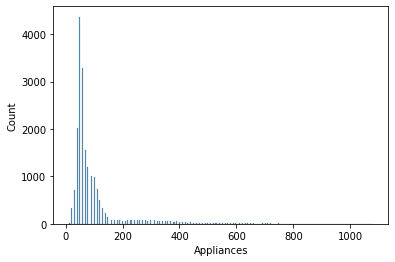

In [16]:
sns.histplot(df['Appliances'])

**75% of Appliance consumption is less than 100 Wh . With the maximum consumption of 1080 Wh , there will be outliers in this column and there are small number of cases where consumption is very high**

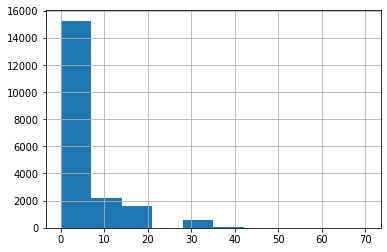

In [17]:
df.lights.hist(bins=10)

In [18]:
df.lights.value_counts()

0     15252
10     2212
20     1624
30      559
40       77
50        9
60        1
70        1
Name: lights, dtype: int64

**Since most of the value in lights column is 0, it wont be playing much role in our model. Hence we drop the lights feature from our dataframe.**

In [19]:
energy_df = energy_df.drop('lights', axis=1)

### **Energy consumption**

**Energy Consumption pattern of the household at different times of the day over different time periods**

In [20]:
energy_df['weekday'] = ((pd.to_datetime(energy_df['date']).dt.dayofweek)// 5 == 0).astype(int)
energy_df['hour'] = pd.to_datetime(energy_df['date']).dt.hour
energy_df['month'] = pd.to_datetime(energy_df['date']).dt.month

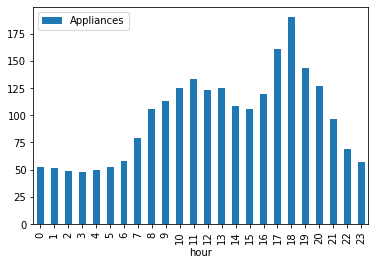

In [21]:
energy_df.groupby('hour').agg({'Appliances' : 'mean'}).plot.bar()

**Above figure is a representation of average energy consumption of appliances at different time of the day over a period of 4.5 months. We observe two peak hours. One at 11 am in the morning and other at 6 PM in the evening. While the peak at 11 am is shallow and low, peak at 6 PM is comparatively higher and sharper.**

**We observe that over the sleeping hours (10 PM - 6 AM) the energy consumption of appliances is around 50 Wh. After about 6 AM, energy consumption starts to rise gradually up until 11 AM (probably due to morning chores). And then gradually decreases to around 100 Wh at about 3 PM. After which the energy consumption drastically shoots up up until 6 PM in the evening (probably due to requirement lights in rooms). However energy consumption of appliances reverts back to 50 Wh, as night approaches and people in the house go to bed at around 10 PM.**

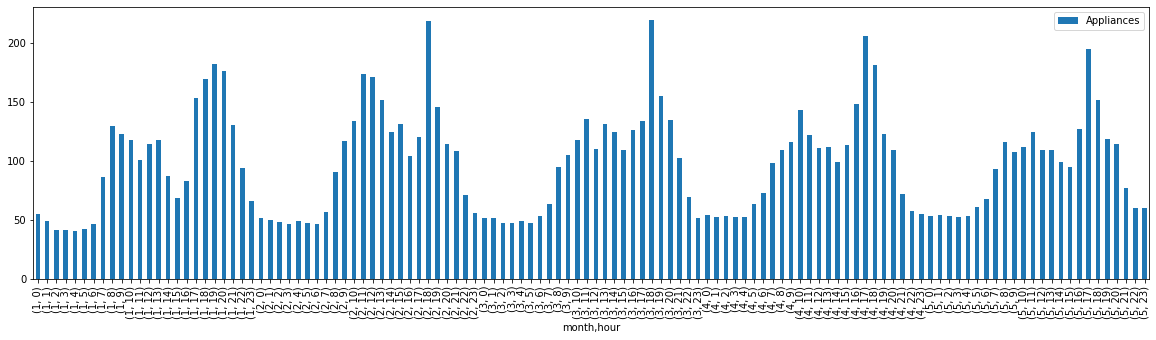

In [22]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
energy_df.groupby(['month','hour']).agg({'Appliances' : 'mean'}).plot.bar(ax=ax)

**A trend of high consumption hours for each month seems to be similar to the over all trend**

**What about weekdays and weekends?**

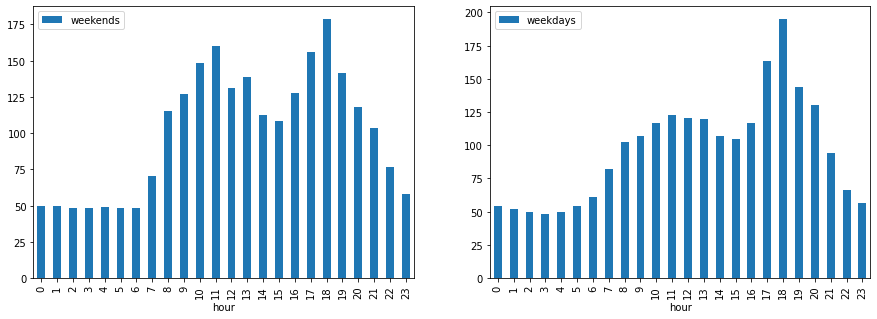

In [23]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
week_df = energy_df.groupby(['weekday','hour']).agg({'Appliances':'mean'}).reset_index(0)
week_df[week_df.weekday==0].Appliances.plot.bar(ax=ax[0], label='weekends')
week_df[week_df.weekday==1].Appliances.plot.bar(ax=ax[1], label='weekdays')
ax[0].legend(loc='best')
ax[1].legend(loc='best')

**We observe that the energy consumption of appliances during the office hours (8 AM - 4 PM) is higher in weekends compared to the weekdays. Also, average overall consumption is higher in weekends is pretty high.**

**Lets look at how temperature and humidity levels vary inside different rooms !**

### **Temperature levels**

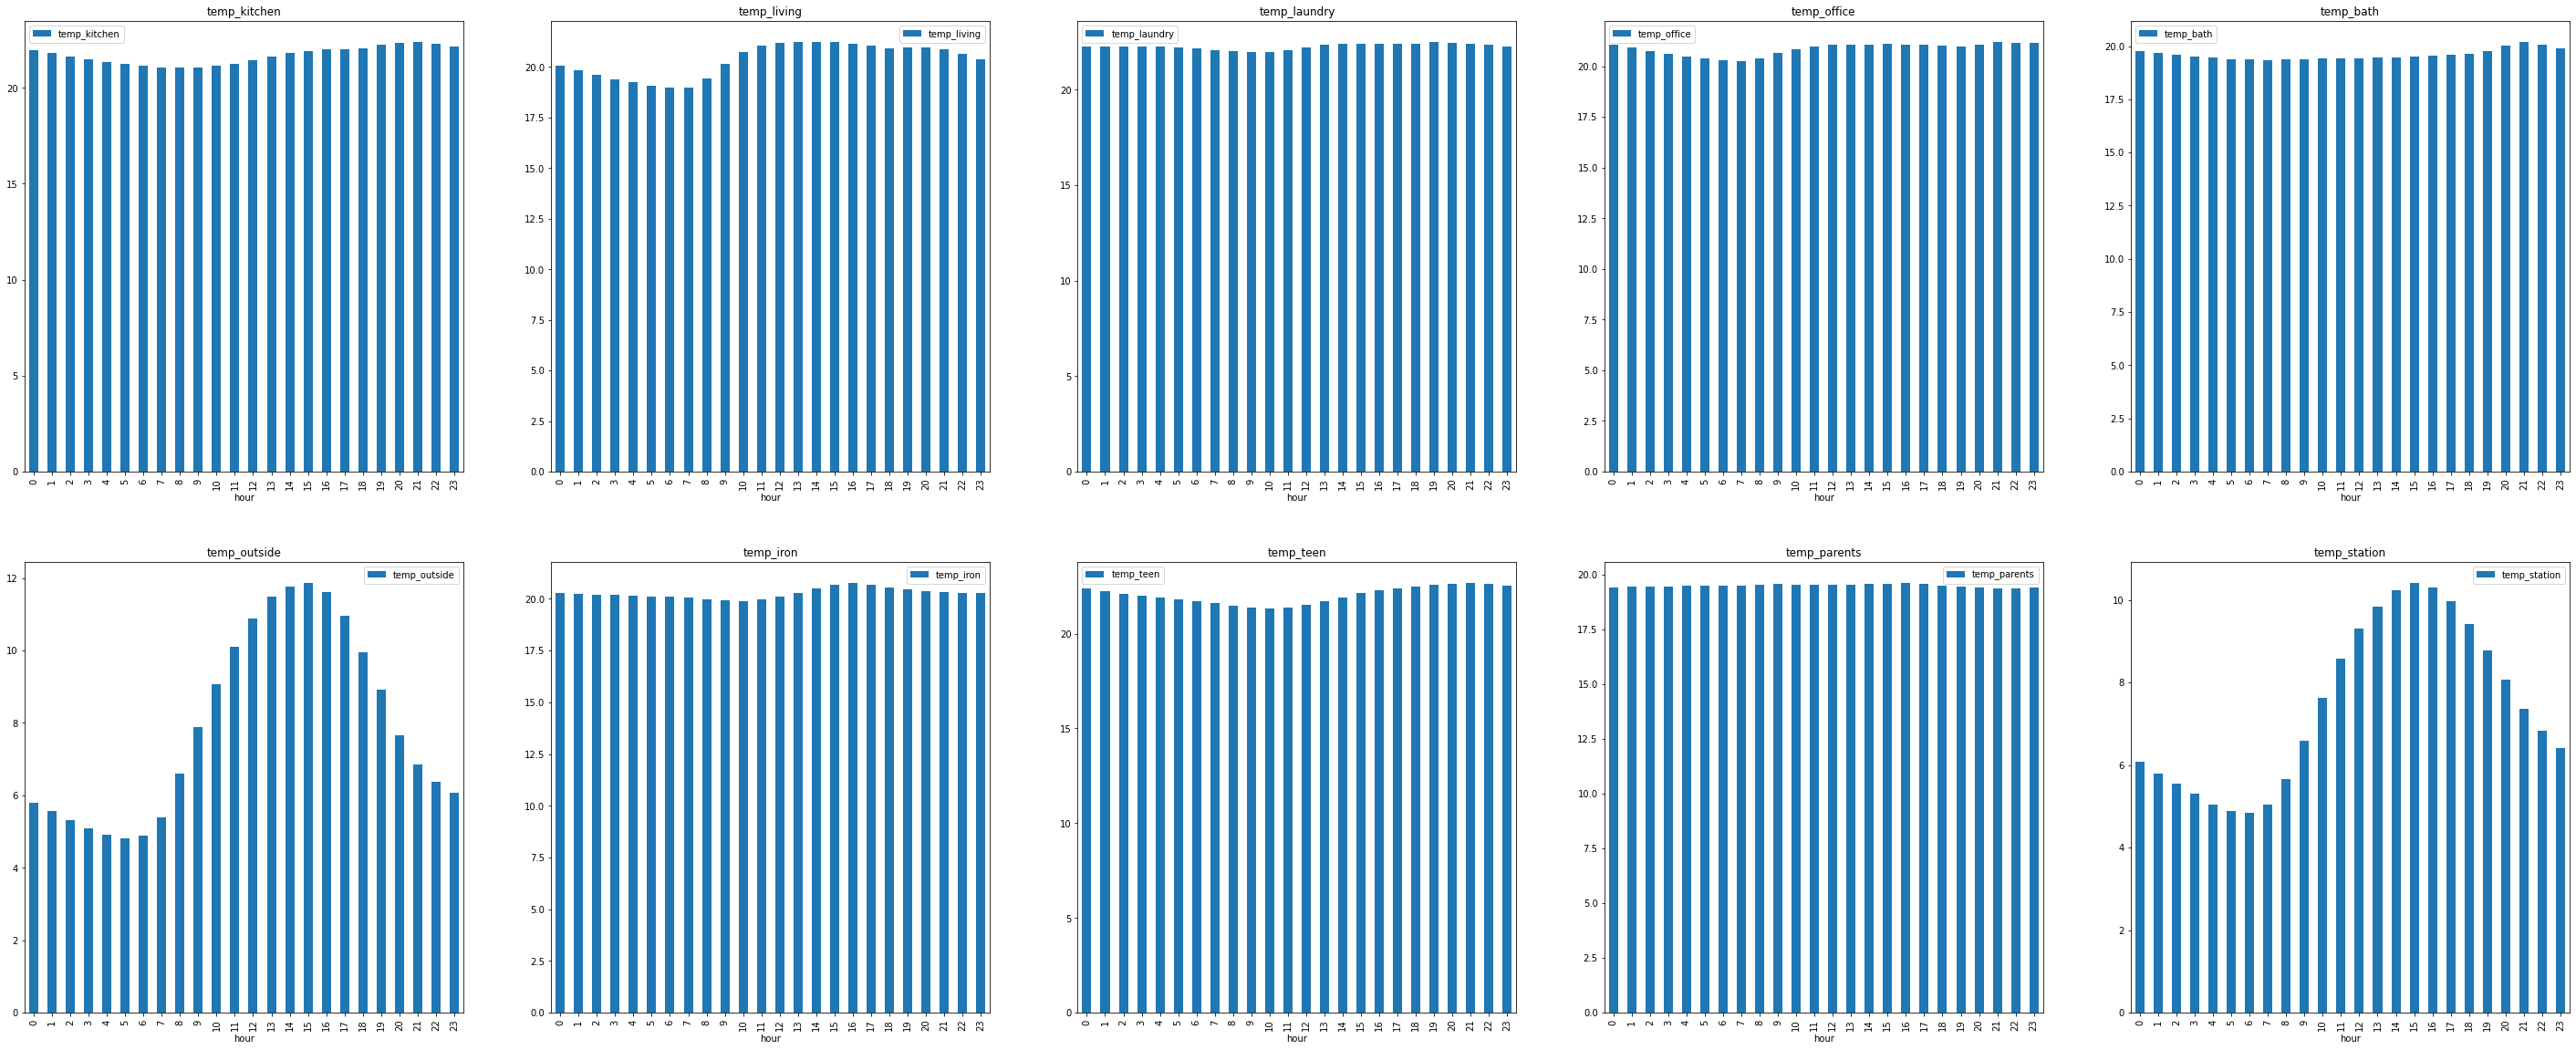

In [24]:
fig, axes = plt.subplots(2,5,figsize=(50,20))
for i, temp in enumerate(temp_dict.values()):
  energy_df.groupby('hour').agg({temp : 'mean'}).plot.bar(ax=axes[i//5, i%5])
  axes[i//5, i%5].legend(loc='best')
  axes[i//5, i%5].set_title(temp)

**The average temperature inside each of the rooms has been almost constant over the day. However the average temperature outside the building and near the station changes over the course of the day. The average night time temperature is around 6 degree C, while average day time temperature peaks at about 2-3 PM in the afternoon.**

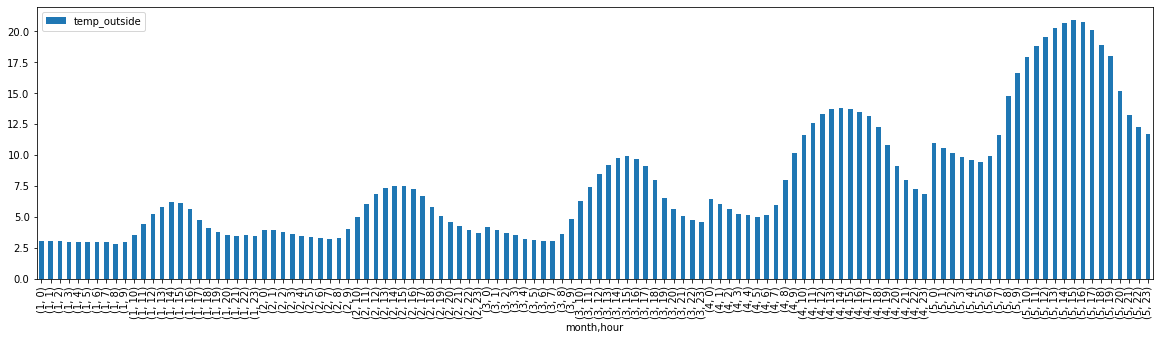

In [25]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
energy_df.groupby(['month','hour']).agg({'temp_outside' : 'mean'}).plot.bar(ax=ax)

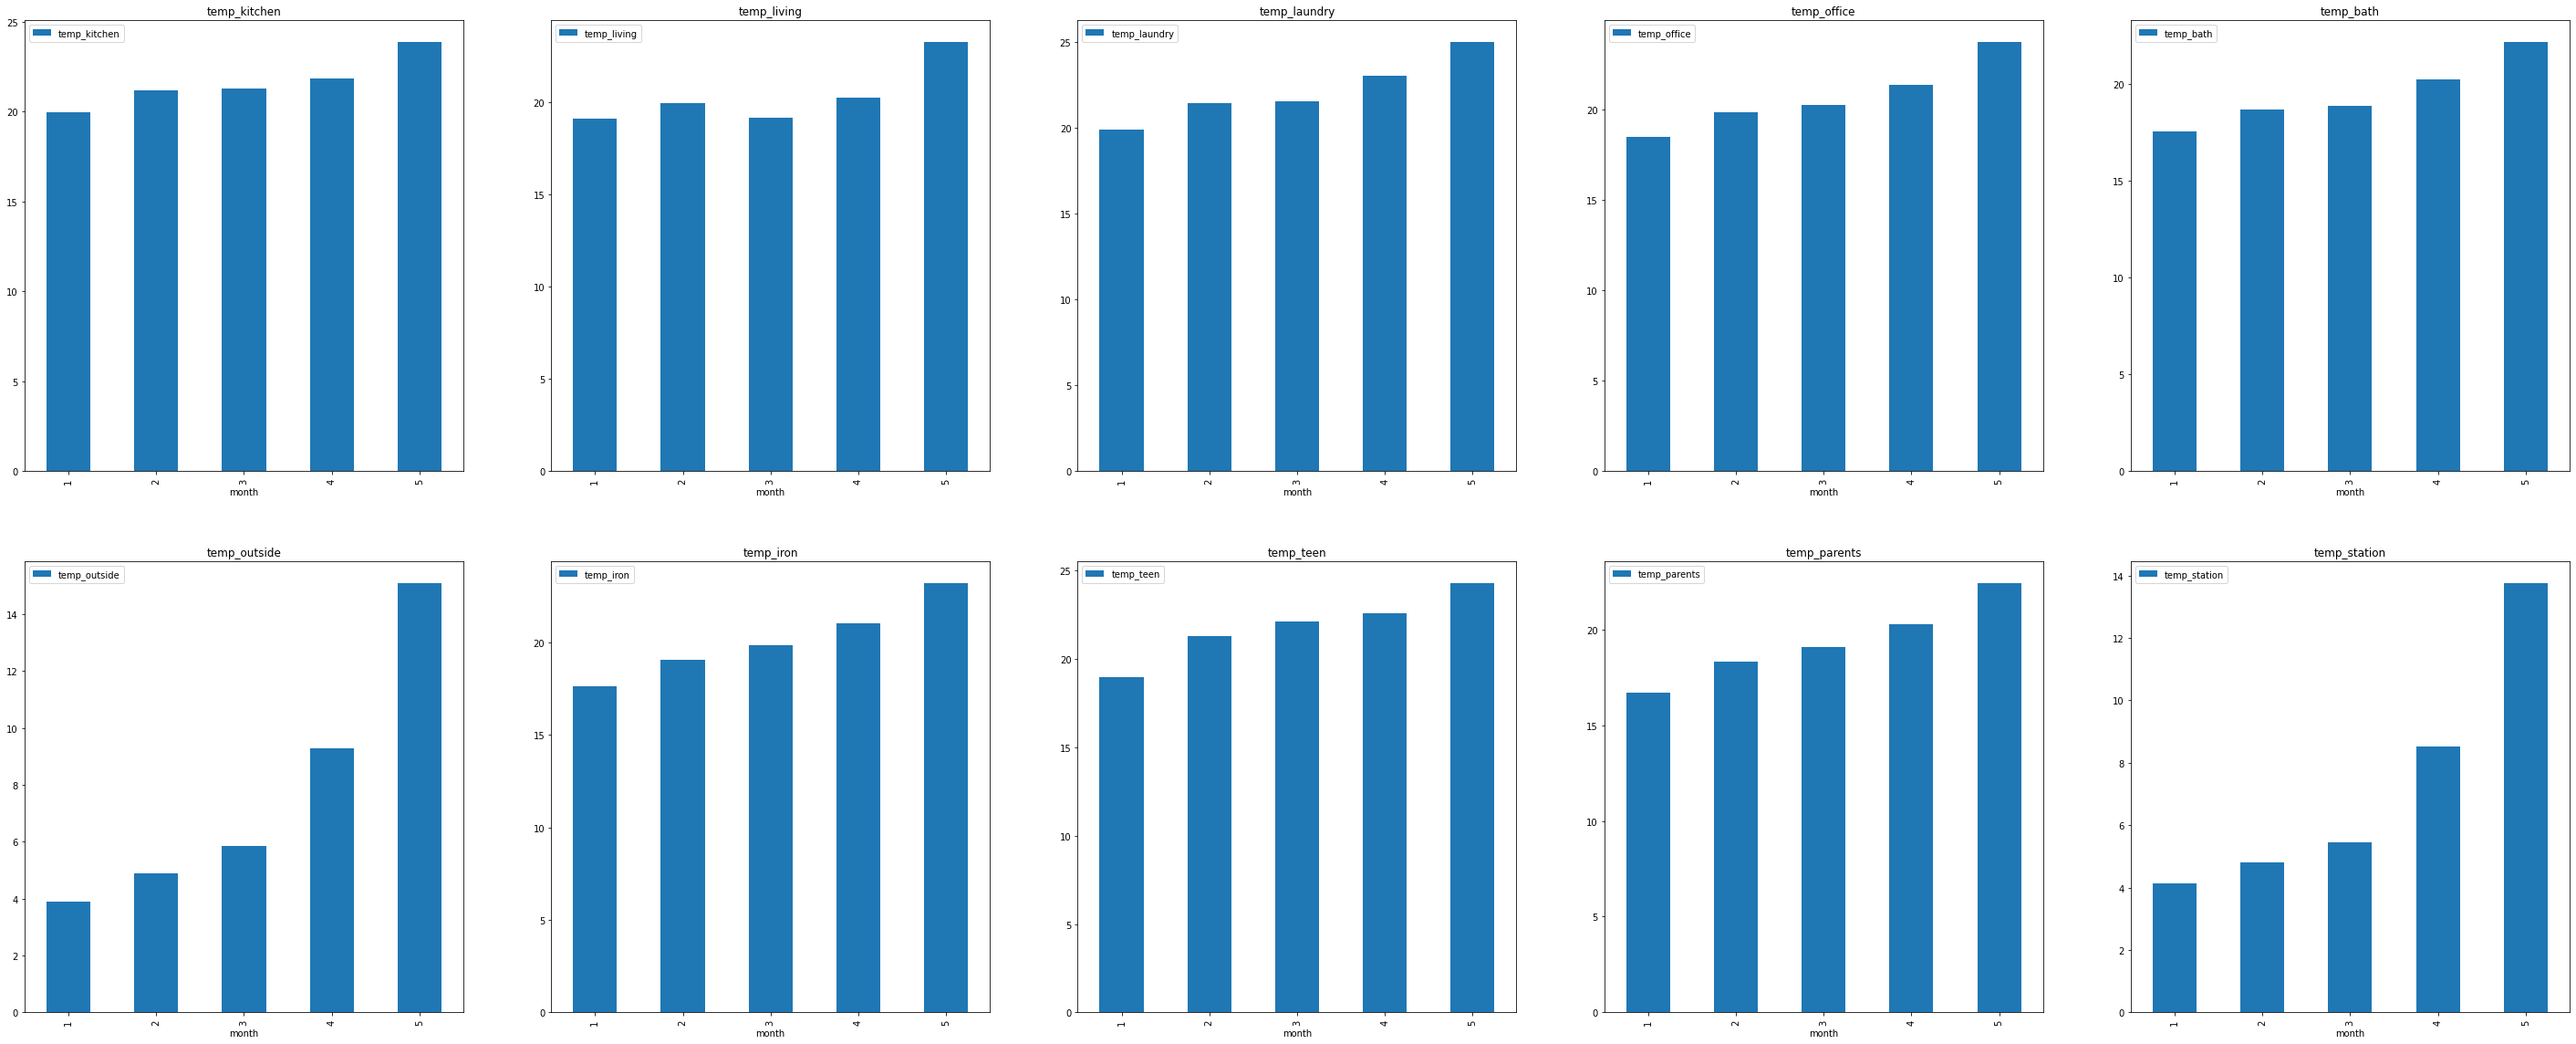

In [26]:
fig, axes = plt.subplots(2,5,figsize=(50,20))
for i, temp in enumerate(temp_dict.values()):
  energy_df.groupby('month').agg({temp : 'mean'}).plot.bar(ax=axes[i//5, i%5])
  axes[i//5, i%5].legend(loc='best')
  axes[i//5, i%5].set_title(temp)

**We observe a significant increasing trend of daytime outside temperatures over the course of 5 months starting from an avg of 4 degree celsius in 1st month to an average of 15 degree celsius in month 5. The outside temperatures seem to have an impact over temperature inside too, although the variance of temperatures inside the building is low, since the temperature inside is controlled. Although the increase temperature seem to have no impact on the appliance consumtion patterns.**

### **Humidity levels**

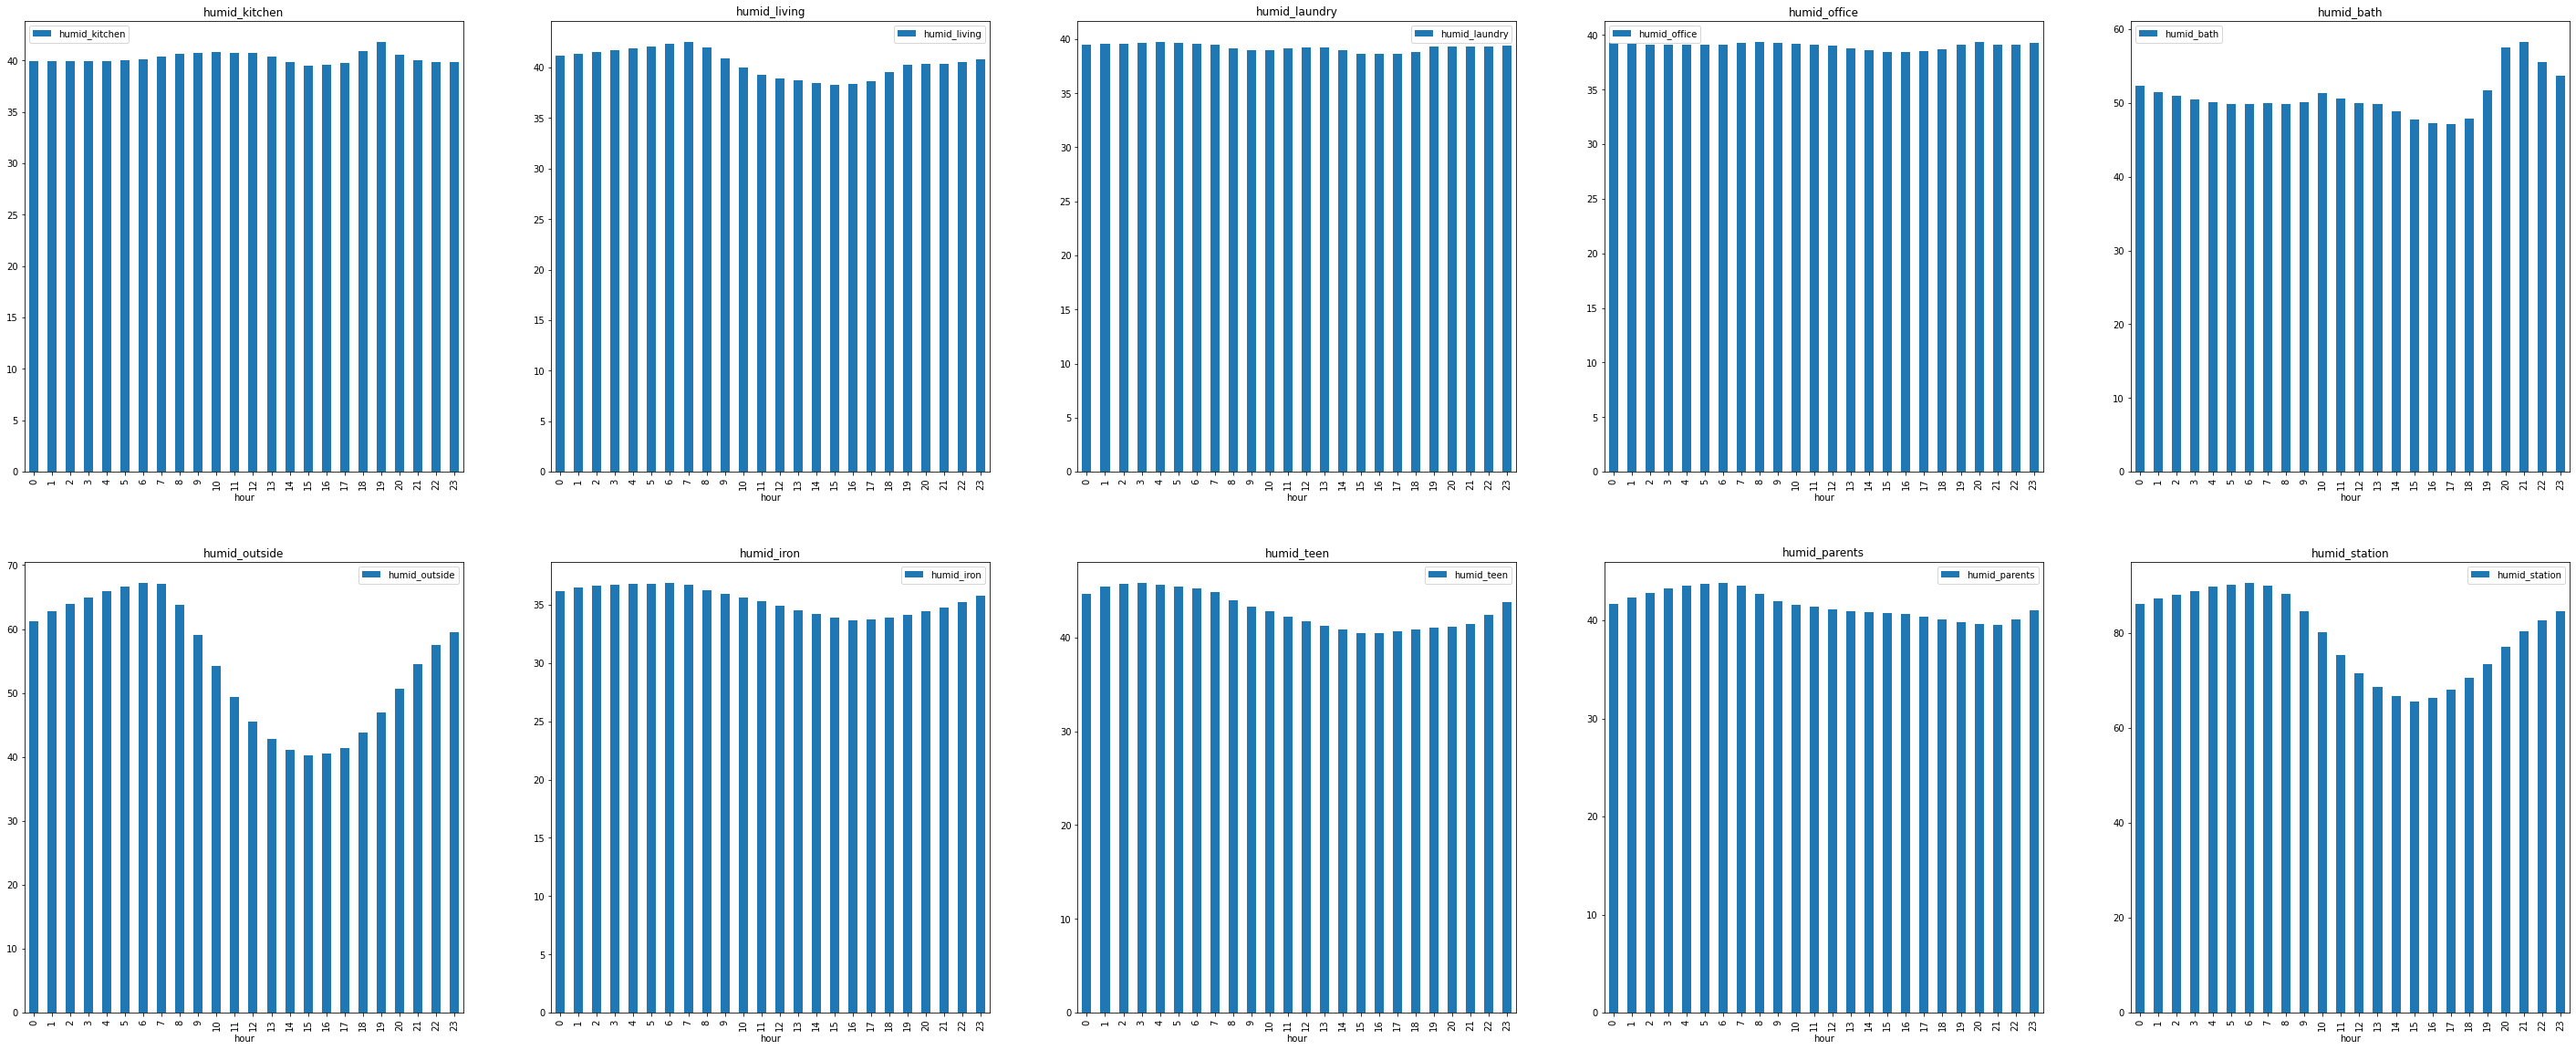

In [27]:
fig, axes = plt.subplots(2,5,figsize=(50,20))
for i, humid in enumerate(humid_dict.values()):
  energy_df.groupby('hour').agg({humid : 'mean'}).plot.bar(ax=axes[i//5, i%5])
  axes[i//5, i%5].legend(loc='best')
  axes[i//5, i%5].set_title(humid)

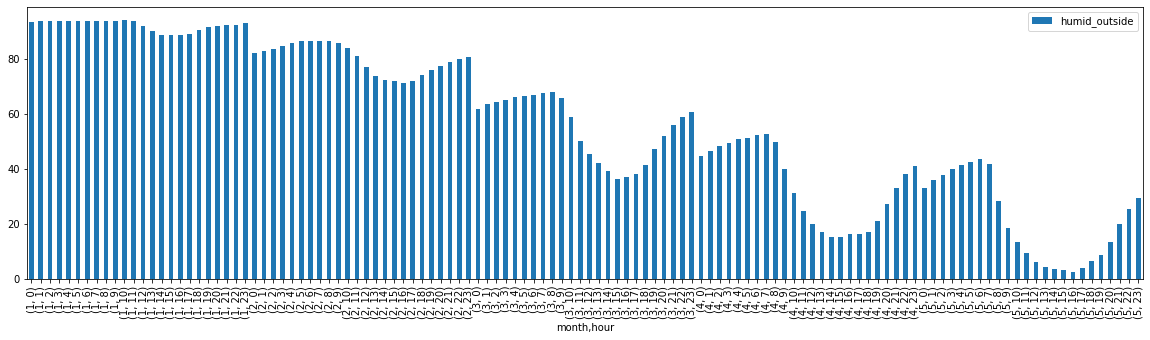

In [28]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
energy_df.groupby(['month','hour']).agg({'humid_outside' : 'mean'}).plot.bar(ax=ax)

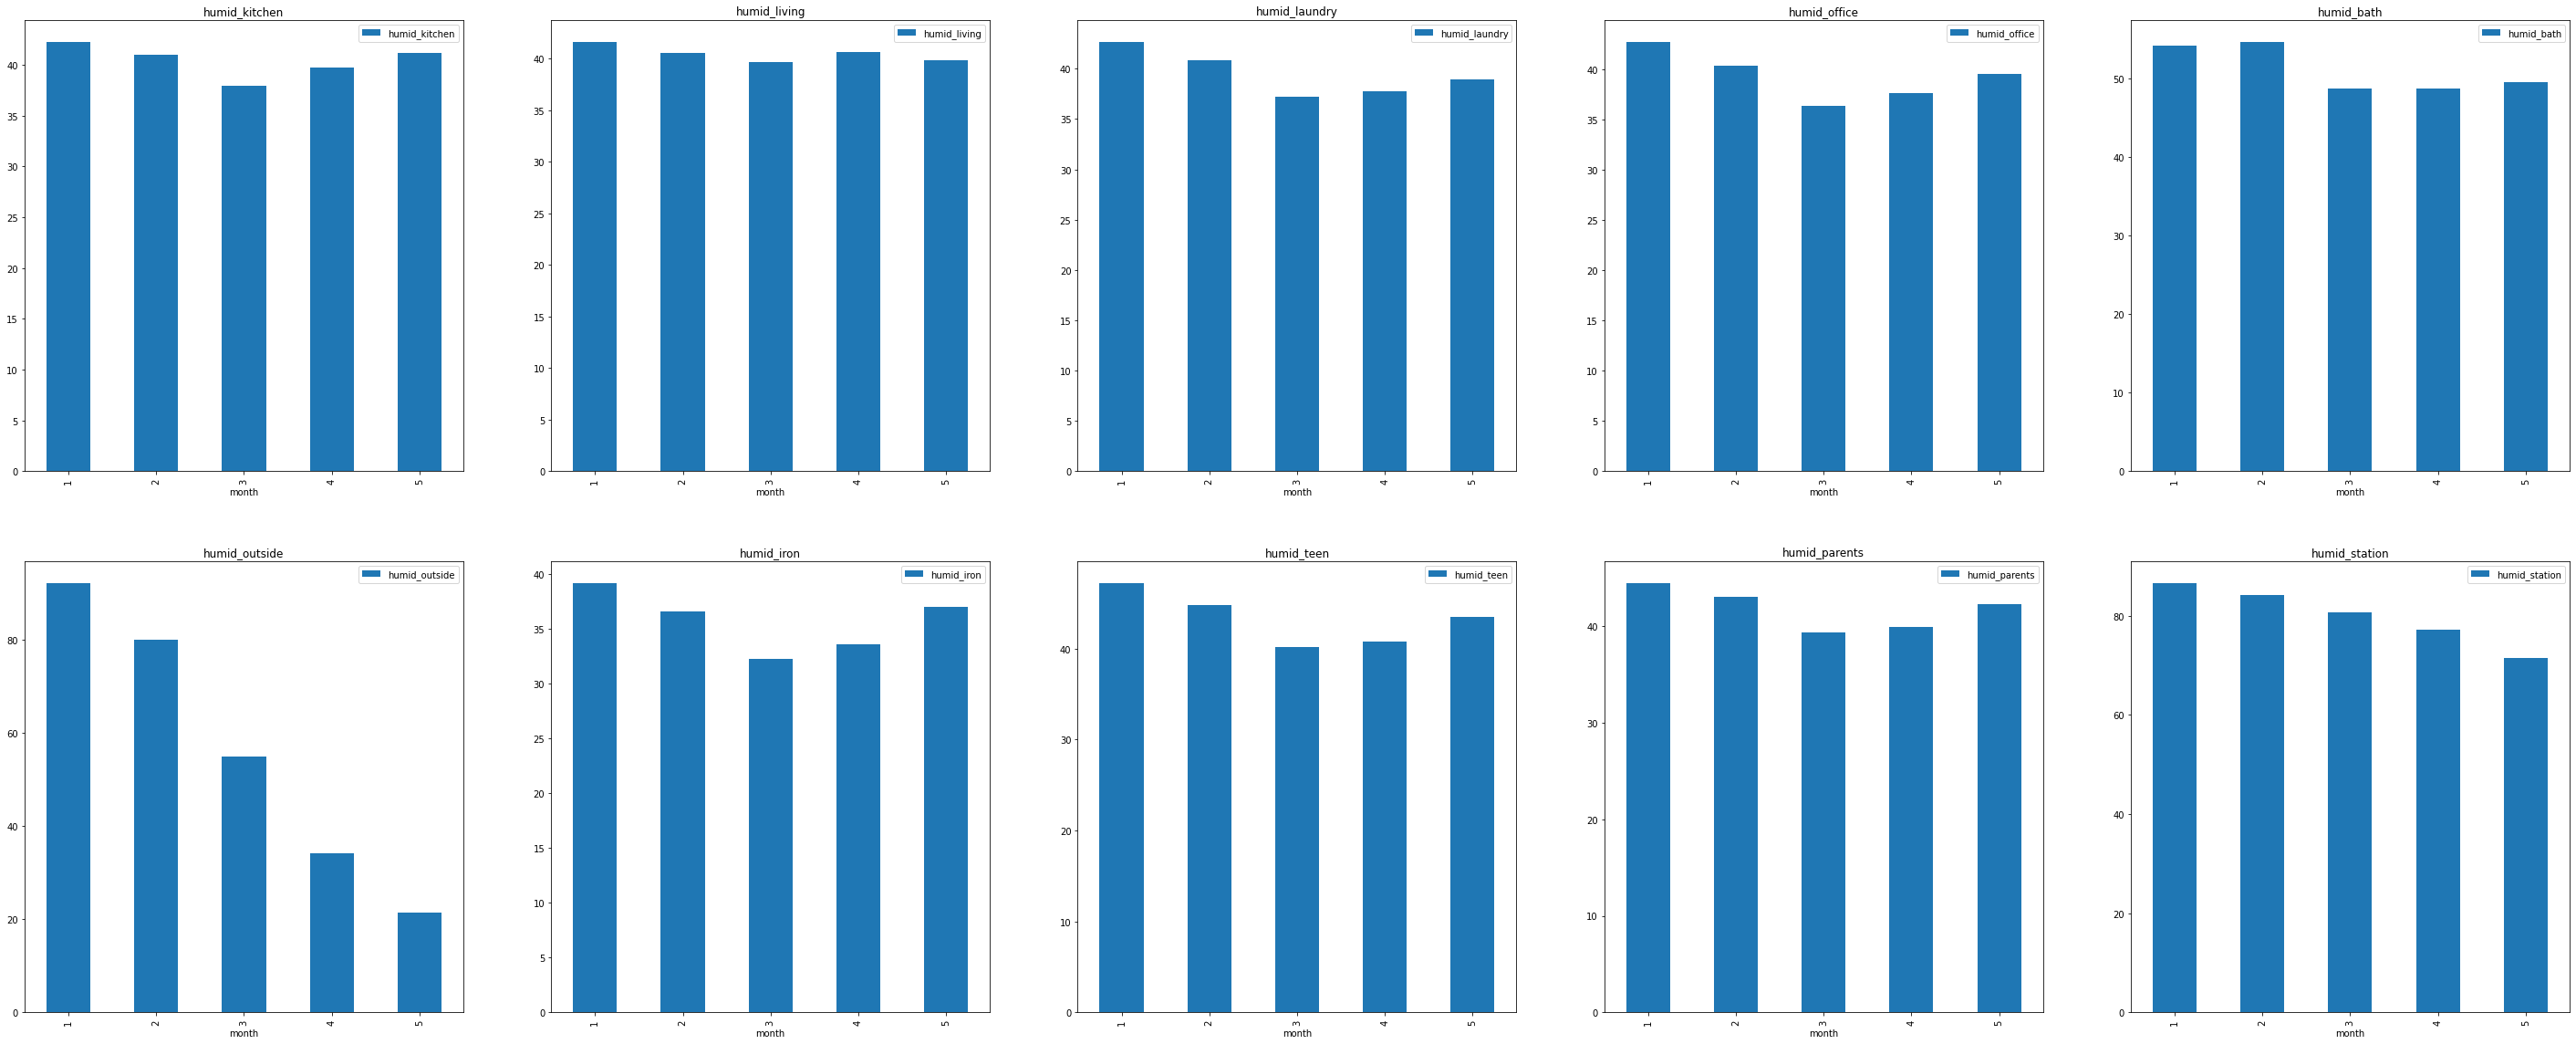

In [29]:
fig, axes = plt.subplots(2,5,figsize=(50,20))
for i, humid in enumerate(humid_dict.values()):
  energy_df.groupby('month').agg({humid : 'mean'}).plot.bar(ax=axes[i//5, i%5])
  axes[i//5, i%5].legend(loc='best')
  axes[i//5, i%5].set_title(humid)

**Although the humidity outside building tend to decrease over months, the humidity inside rooms seem to be unaffected. The humidity levels outside seem to be negatively correlated to with the temperature levels outside. Lets check !**

In [30]:
energy_df[['temp_outside', 'humid_outside']].corr()

,temp_outside,humid_outside
temp_outside,1.000000,-0.672137
humid_outside,-0.672137,1.000000


**Indeed there is a strong negative correlation between temperature and humidity levels outside. As temperature increases, moisture levels in the air decreases. We also observe that during the day time when the temperatures are high, humidity levels are low.**

**Lets look at correlation matrix of temperature and humidity levels**

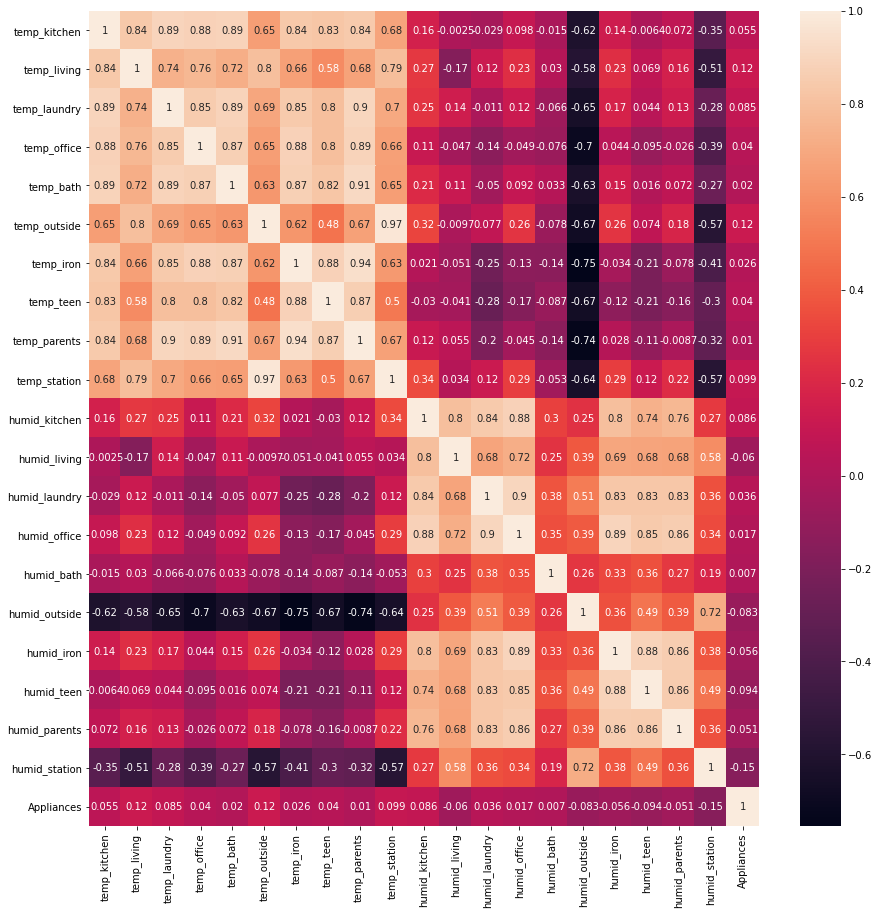

In [31]:
cols = list(temp_dict.values())
cols.extend(list(humid_dict.values()))
cols.extend(['Appliances'])
fig, ax = plt.subplots(1,1,figsize=(15,15))
sns.heatmap(energy_df[cols].corr(), ax=ax, annot=True)

**OBSERVATIONS :**

* **From the correlation graph we clearly observe that the features related to temperature and features related to humidity have positive correlation within themselves whereas have a a very low or negative correlation with each other.**
* **Humidity outside have a strong negative correlation with temperature levels as already discussed.**
* **Apart from that we observe that a couple features such as humidity at station, temperature outside the building and temperature in the living room have a comparatively high absolute correlation (above 0.12) with Appliances energy consumption.**

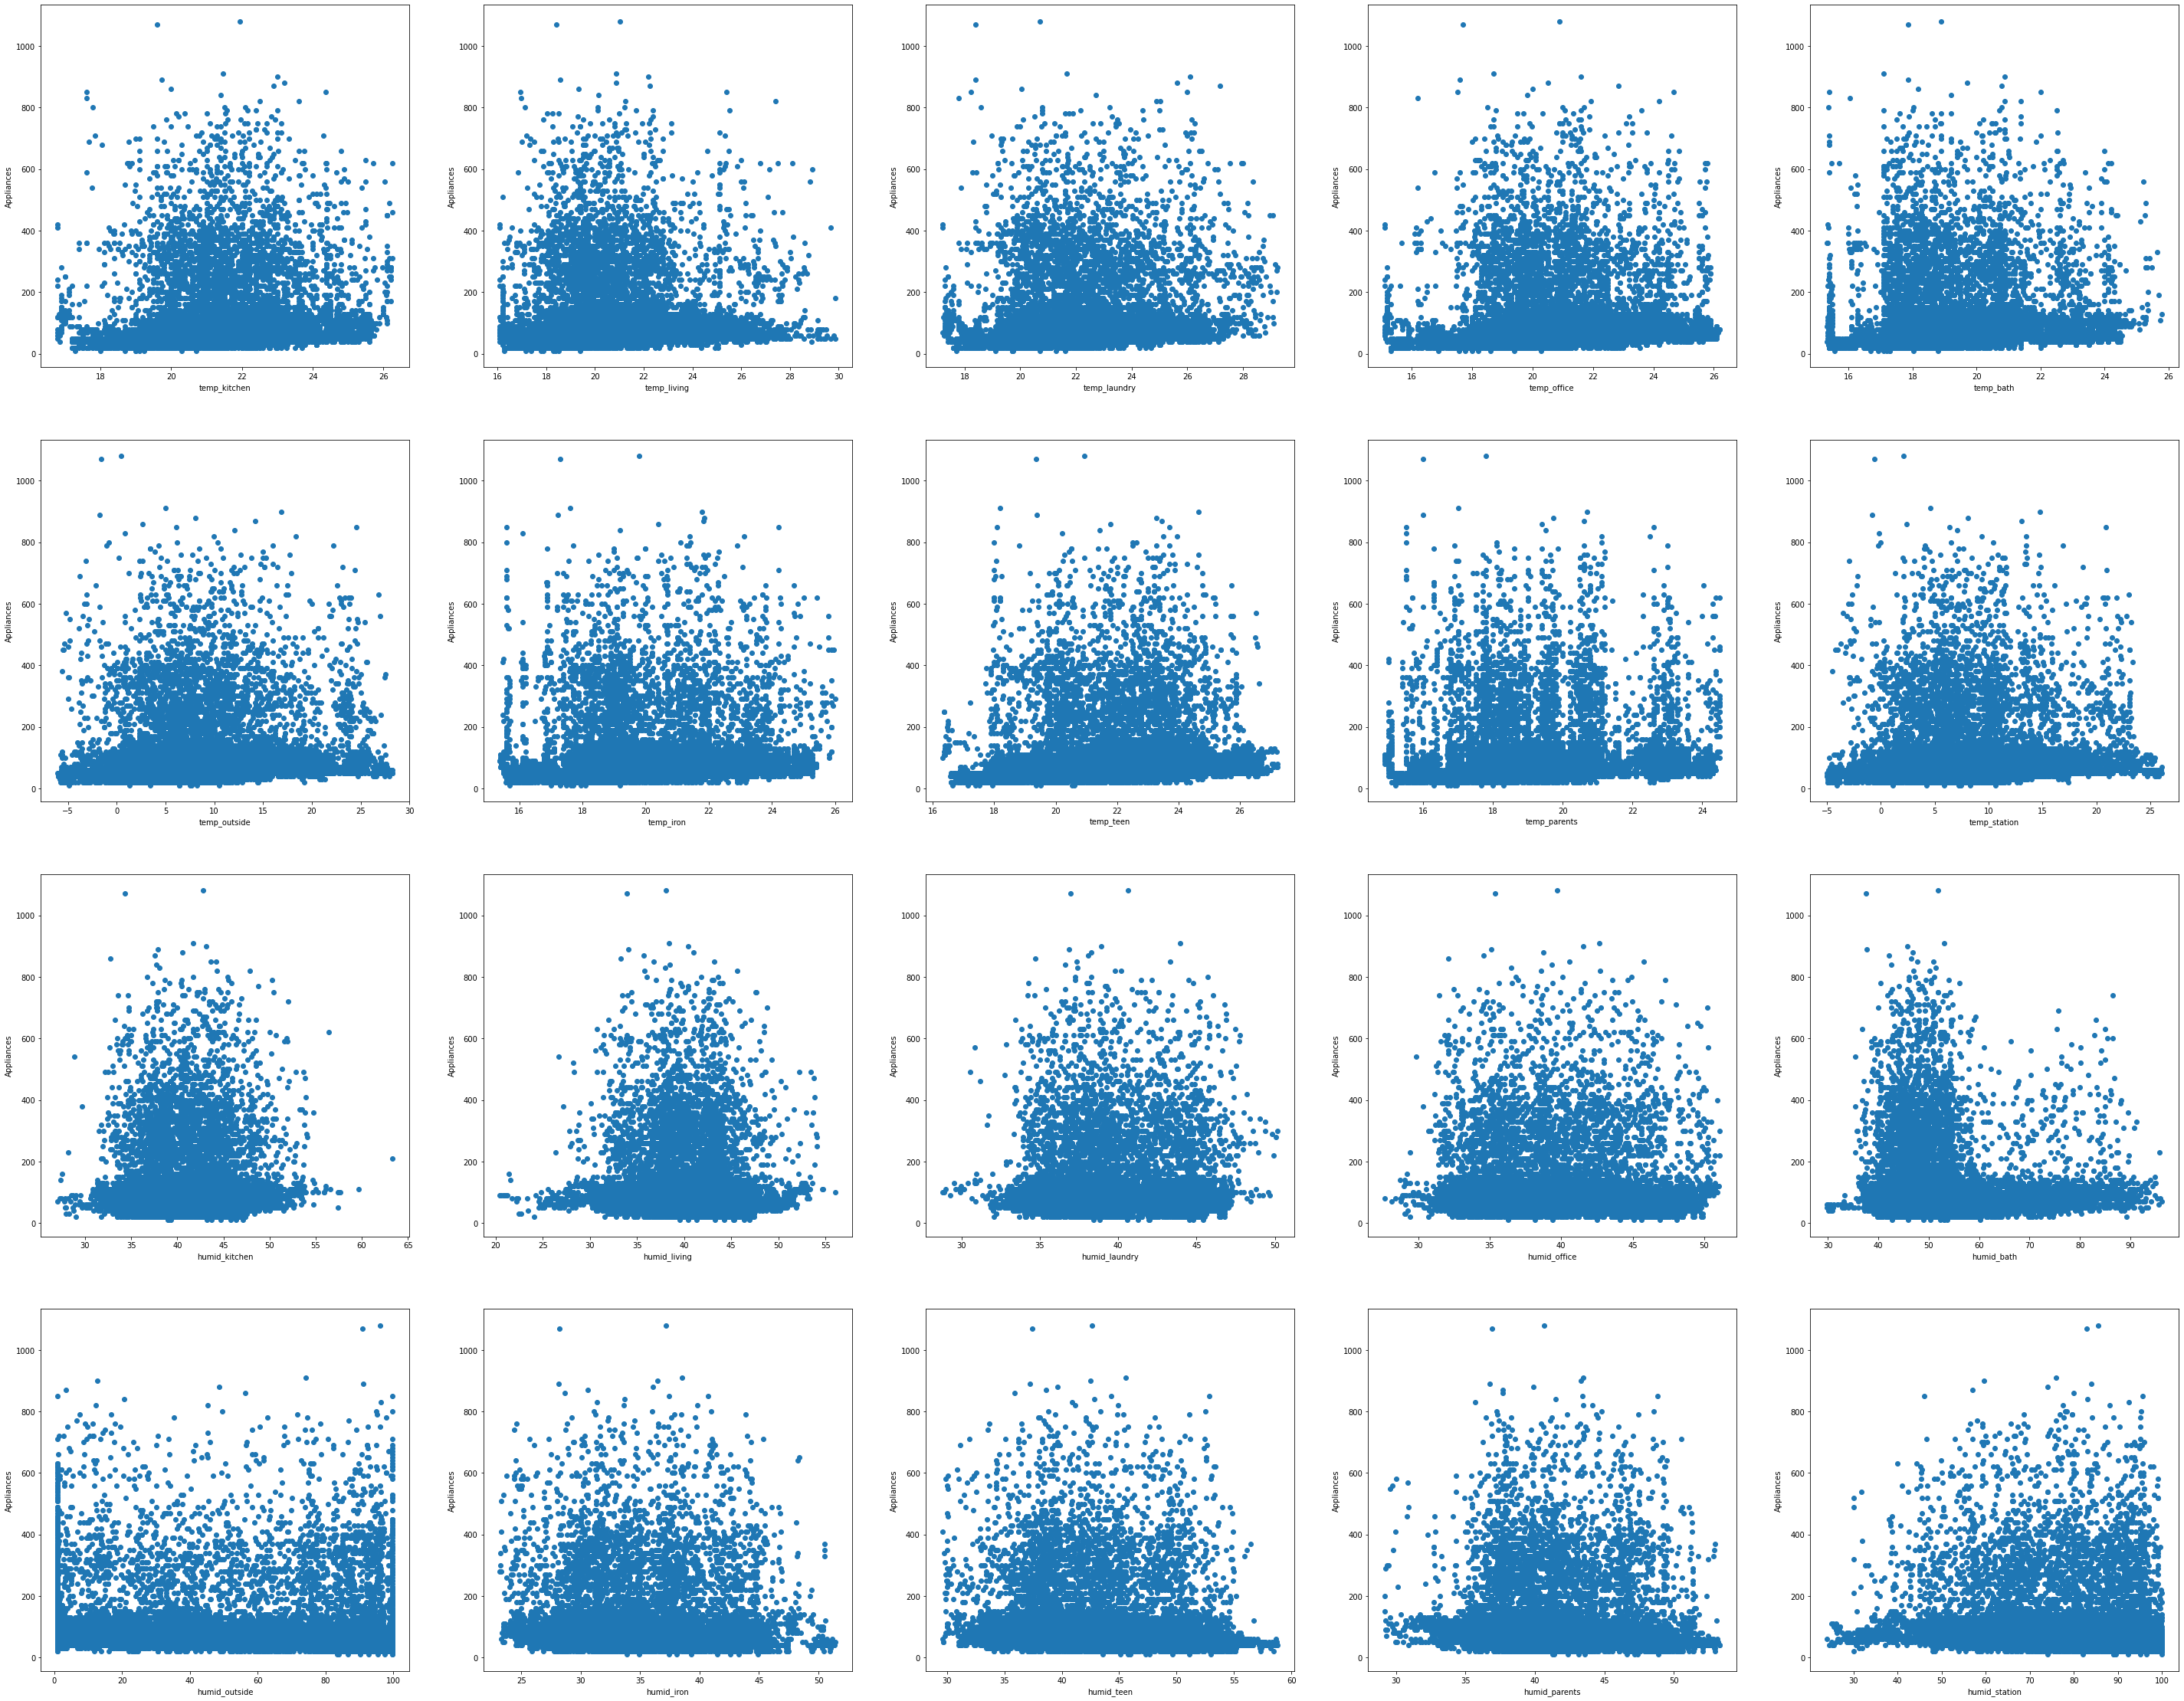

In [32]:
# let us plot the variation of energy consumption with these variables
fig, axes = plt.subplots(4,5,figsize = (50,40))
for i, col in enumerate(cols[:-1]):
  ax = axes[i//5, i%5]
  ax.scatter(energy_df[col], energy_df['Appliances'])
  ax.set_xlabel(col)
  ax.set_ylabel('Appliances')

**Lets look at the dependence of appliance energy consumption on newly created variables !**

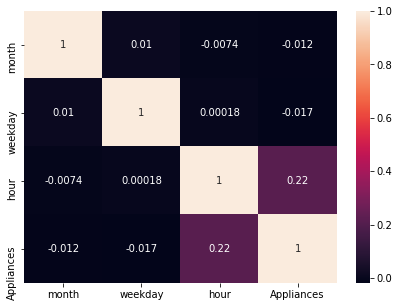

In [33]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
sns.heatmap(energy_df[['month', 'weekday', 'hour', 'Appliances']].corr(), annot=True, ax=ax)

* **As we have observed earlier as well, there seenms to be no correlation between month and the observed energy use i.e. the enegy consumption pretty much remains similar over all months. Similarly there is no direct effect of weekdays on appliance energy consumption.**
* **Although there is a correlation of 0.22 between hour and appliances**

In [34]:
def create_session(x):
  if x <= 6 or x >= 22:
    return 1
  elif x>6 and x <=15:
    return 2
  else:
    return 3

In [35]:
# lets create a new column based on our observations
energy_df['session'] = energy_df['hour'].apply(lambda x : create_session(x))

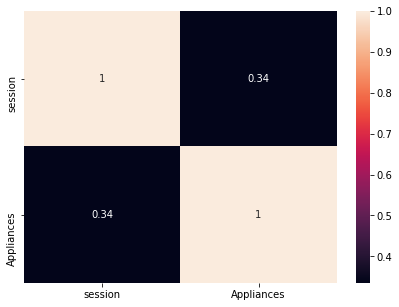

In [36]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
sns.heatmap(energy_df[['session', 'Appliances']].corr(), ax = ax, annot=True)

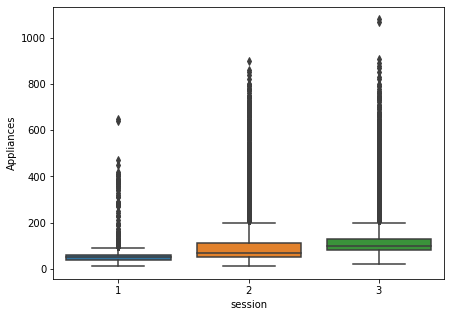

In [37]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
sns.boxplot(x='session',y='Appliances',data=energy_df, ax = ax)

**We were now able to increase the correlation to 0.34 by making creating this new row. We see a clear distinction of power consumtion in different sessions.**

**Lets look at features related to weather as well.**

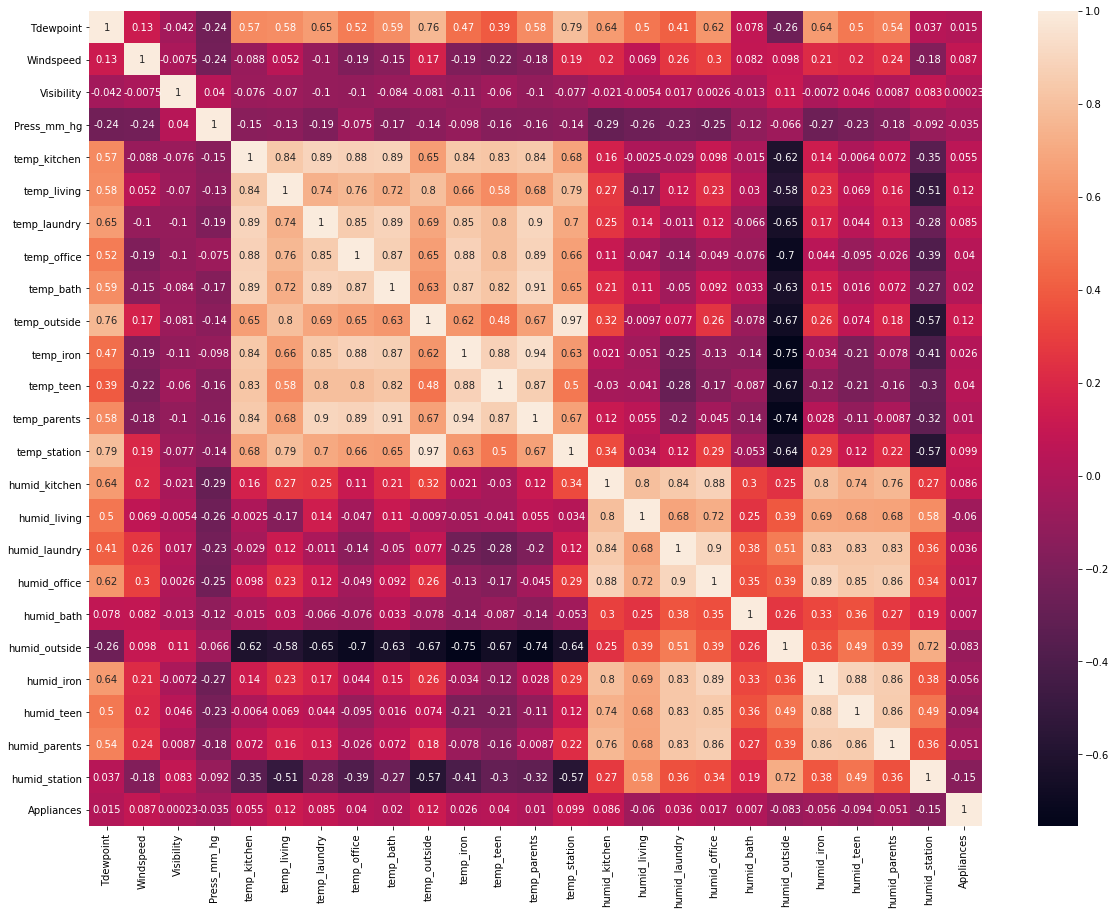

In [38]:
fig,ax = plt.subplots(1,1,figsize=(20,15))
sns.heatmap(energy_df[weather_cols + cols].corr(), ax = ax, annot=True)

**Tdewpoint shows a high correlation with most of the tempearture and humidity level features than any other weather parameters. Pressure, windspeed and visibiltiy show little to know correlation. We might need to include these only these feaatures in our final model**

**Lets now deep dive into reducing the temperature and humidity parameters through some feature engineering and come up with features that explain maximum variability.**

In [39]:
temp_cols = list(set(list(temp_dict.values())) - {'temp_outside', 'temp_station'})
energy_df['mean_temp'] = energy_df[temp_cols].mean(axis=1)
energy_df[['mean_temp', 'Appliances']].corr()

,mean_temp,Appliances
mean_temp,1.00000,0.05474
Appliances,0.05474,1.00000


**Since most of the temperature variables inside the room show little to know correlation with target variable, lets try to find components that could explain maximum variance, which might improve the correlation with target variable as well.**

**Before doing PCA, I need to split the data into train and test, and fit PCA on train set**

### **PCA on temperatures**

In [40]:
train_energy_df, test_energy_df = train_test_split(energy_df, test_size=0.2, random_state=1)

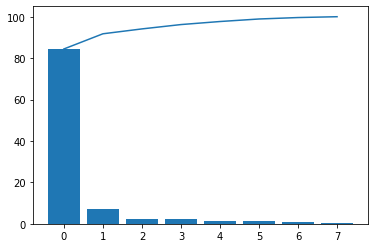

In [41]:
pca = PCA()
pca.fit(train_energy_df[temp_cols])
temp_pca = pca.transform(energy_df[temp_cols])
variance = pca.explained_variance_ratio_*100
plt.bar(range(len(variance)), variance)
plt.plot(range(len(variance)), np.cumsum(variance))

In [42]:
variance

array([84.42749838,  7.33014216,  2.3562388 ,  2.09550508,  1.47195967,
        1.21891325,  0.69977714,  0.39996553])

First two components seem to explain more than 91 % of variance in data.

In [43]:
for i in range(temp_pca.shape[1]):
  energy_df[f'temp_pca{i+1}'] = temp_pca[:,i]

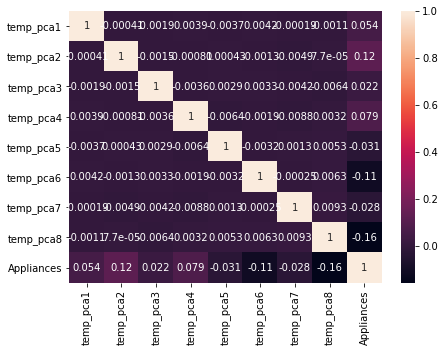

In [44]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
sns.heatmap(energy_df[['temp_pca1', 'temp_pca2', 'temp_pca3', 'temp_pca4','temp_pca5', 'temp_pca6', 'temp_pca7', 'temp_pca8', 'Appliances']].corr(), ax = ax, annot=True)

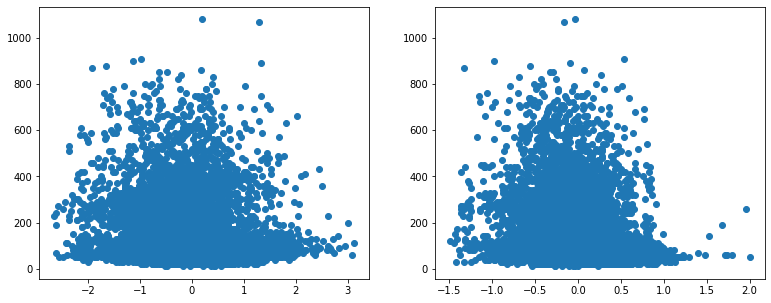

In [45]:
fig, axes = plt.subplots(1,2,figsize=(13,5))
for i, j in enumerate((6,8)):
  axes[i].scatter(energy_df[f'temp_pca{j}'], energy_df['Appliances'])

In [46]:
#Lets look at components of humid_pca4
dict(zip(temp_cols, pca.components_[7,:]))

{'temp_bath': -0.2173285515914466,
 'temp_iron': -0.2402654099158852,
 'temp_kitchen': 0.6252020918393116,
 'temp_laundry': -0.2968959599105869,
 'temp_living': -0.11736304703987983,
 'temp_office': -0.0984547302609294,
 'temp_parents': 0.6025874320322222,
 'temp_teen': -0.17157195238503245}

### **PCA on humidity**

In [47]:
humid_cols = list(set(list(humid_dict.values())) - {'humid_outside', 'humid_station'})
energy_df['mean_humid'] = energy_df[temp_cols].mean(axis=1)
energy_df[['mean_humid', 'Appliances']].corr()

,mean_humid,Appliances
mean_humid,1.00000,0.05474
Appliances,0.05474,1.00000


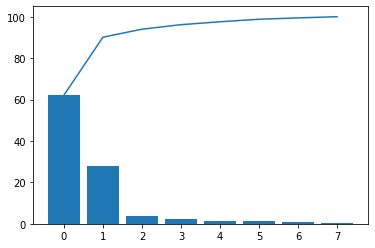

In [48]:
pca = PCA()
pca.fit(train_energy_df[humid_cols])
humid_pca = pca.transform(energy_df[humid_cols])
variance = pca.explained_variance_ratio_*100
plt.bar(range(len(variance)), variance)
plt.plot(range(len(variance)), np.cumsum(variance))

In [49]:
variance

array([62.09137315, 28.02035975,  3.84761759,  2.19313449,  1.40502588,
        1.22143306,  0.64956943,  0.57148664])

In [50]:
for i in range(humid_pca.shape[1]):
  energy_df[f'humid_pca{i+1}'] = humid_pca[:,i]

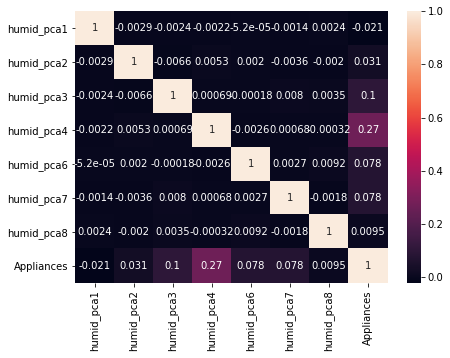

In [51]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
sns.heatmap(energy_df[['humid_pca1', 'humid_pca2', 'humid_pca3', 'humid_pca4', 'humid_pca6', 'humid_pca7', 'humid_pca8', 'Appliances']].corr(), ax = ax, annot=True)

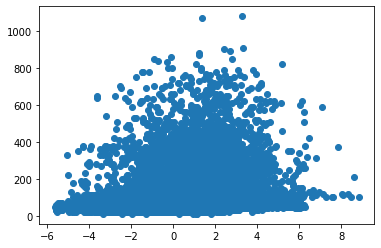

In [52]:
plt.scatter(energy_df['humid_pca4'], energy_df['Appliances'])

In [53]:
#Lets look at components of humid_pca4
dict(zip(humid_cols, pca.components_[3,:]))

{'humid_bath': -0.00505235245721385,
 'humid_iron': 0.0789769451298035,
 'humid_kitchen': 0.4123122284268884,
 'humid_laundry': 0.2908803708815089,
 'humid_living': -0.5395785231761465,
 'humid_office': 0.41021262197258834,
 'humid_parents': -0.018904279237056856,
 'humid_teen': -0.5285334448509872}

In [54]:
energy_df['diff_temp'] = energy_df['temp_outside'] - energy_df['mean_temp']
energy_df[['diff_temp', 'Appliances']].corr()

,diff_temp,Appliances
diff_temp,1.00000,0.12411
Appliances,0.12411,1.00000


# **Modeling with PCA features**

In [55]:
final_features = ['temp_pca1', 'temp_pca2', 'humid_pca1', 'humid_pca2', 'temp_outside', 'humid_outside', 'session', 'Windspeed', 'Press_mm_hg', 'Appliances']

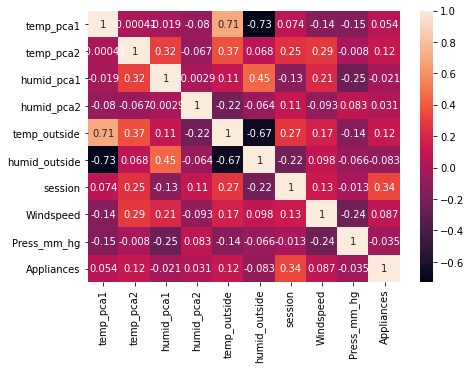

In [56]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
sns.heatmap(energy_df[final_features].corr(), ax = ax, annot=True)

In [57]:
final_train_df, final_test_df = train_test_split(energy_df[final_features], test_size = 0.2, random_state = 1)

In [58]:
X_train, y_train = final_train_df.drop('Appliances', axis=1), final_train_df['Appliances']
X_test, y_test = final_test_df.drop('Appliances', axis=1), final_test_df['Appliances']

In [59]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [60]:
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train.values.reshape([-1,1])).flatten()
y_test = sc_y.transform(y_test.values.reshape([-1,1])).flatten()

**The ML regressor models that we use are :**
* **Lasso Regressor**
* **Ridge Regressor**
* **KNeighbors Regressor**
* **Support Vector Regressor**
* **Random Forest Regressor**
* **Extra Tree Regressor**
* **Gradient Boosting Regressor**
* **XGB Regressor**
* **MLP Regressor**

In [61]:
models = [
           ['Lasso: ', Lasso()],
           ['Ridge: ', Ridge()],
           ['KNeighborsRegressor: ',  neighbors.KNeighborsRegressor()],
           ['SVR:' , SVR(kernel='rbf')],
           ['RandomForest ',RandomForestRegressor()],
           ['ExtraTreeRegressor :',ExtraTreesRegressor()],
           ['GradientBoostingRegressor: ', GradientBoostingRegressor()] ,
           ['XGBRegressor: ', xgb.XGBRegressor()] ,
           ['MLPRegressor: ', MLPRegressor(  activation='relu', solver='adam',learning_rate='adaptive',max_iter=1000,learning_rate_init=0.01,alpha=0.01)]
         ]

In [62]:
model_data = []
for name,curr_model in models :
    curr_model_data = {}
    curr_model.random_state = 78
    curr_model_data["Name"] = name
    start = time.time()
    curr_model.fit(X_train,y_train)
    end = time.time()
    curr_model_data["Train_Time"] = end - start
    curr_model_data["Train_R2_Score"] = r2_score(y_train,curr_model.predict(X_train))
    curr_model_data["Test_R2_Score"] = r2_score(y_test,curr_model.predict(X_test))
    curr_model_data["Test_RMSE_Score"] = np.sqrt(mean_squared_error(y_test,curr_model.predict(X_test)))
    model_data.append(curr_model_data)

[17:41:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [63]:
results_df = df = pd.DataFrame(model_data)

In [64]:
results_df

,Name,Train_Time,Train_R2_Score,Test_R2_Score,Test_RMSE_Score
0,Lasso:,0.005240,0.000000,-0.000777,1.028791
1,Ridge:,0.002321,0.114935,0.123802,0.962630
2,KNeighborsRegressor:,0.026977,0.682037,0.474243,0.745677
3,SVR:,13.716195,0.151903,0.121470,0.963910
4,RandomForest,13.448093,0.938334,0.554200,0.686638
5,ExtraTreeRegressor :,3.668972,1.000000,0.638083,0.618676
6,GradientBoostingRegressor:,3.877402,0.273617,0.218109,0.909350
7,XGBRegressor:,0.991150,0.266922,0.216679,0.910182
8,MLPRegressor:,6.751705,0.329281,0.295109,0.863414


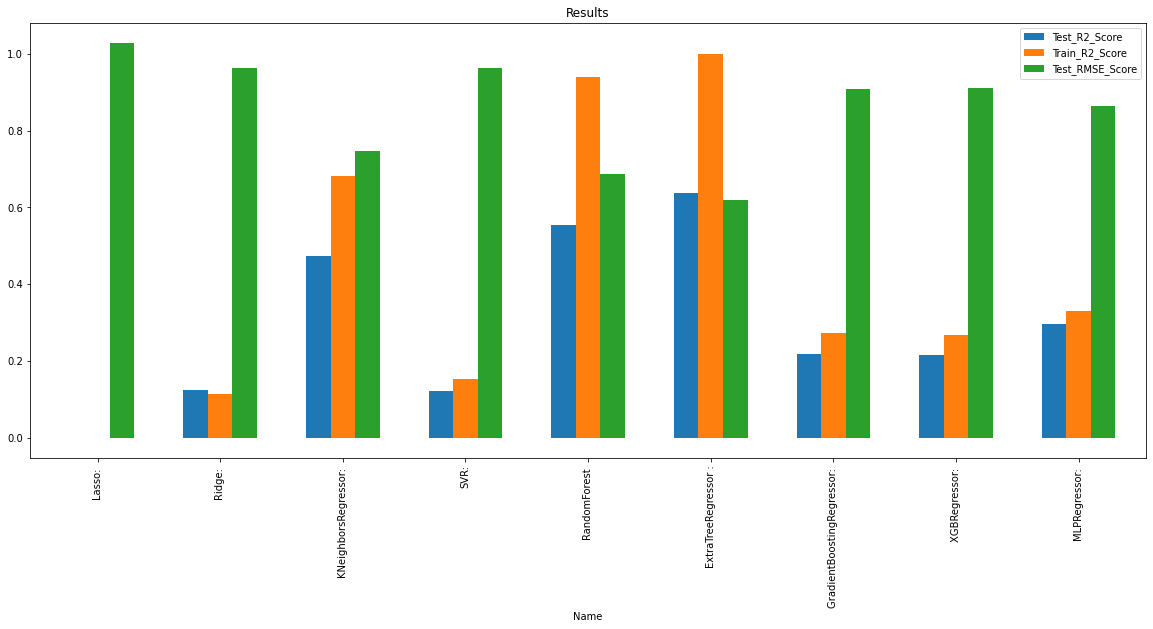

In [65]:
results_df.plot.bar(x="Name", y=['Test_R2_Score' , 'Train_R2_Score' , 'Test_RMSE_Score'], title = 'Results' , width = .6, figsize= (20,8))

**OBSERVATIONS :**

* **Extra Tree Regressor performs the best so far with a R2 score of 0.59 and RMSE of 0.65.**
* **Lasso regression is the worst performing model so far.**

# **Hyper-parameter Tuning**

In [67]:
from sklearn.model_selection import GridSearchCV
param_grid = [{
              'max_depth': [80, 150, 200,250],
              'n_estimators' : [100,150,200,250],
              'max_features': ["auto", "sqrt", "log2"]
            }]
reg = ExtraTreesRegressor(random_state=40)
grid_search = GridSearchCV(estimator = reg, param_grid = param_grid, cv = 5, n_jobs = -1 , scoring='r2' , verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 11.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                           criterion='mse', max_depth=None,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           max_samples=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100, n_jobs=None,
                                           oob_score=False, random_state=40,
                                           verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_g

In [68]:
grid_search.best_params_

{'max_depth': 80, 'max_features': 'sqrt', 'n_estimators': 250}

In [69]:
grid_search.best_estimator_

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=80, max_features='sqrt', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=250, n_jobs=None, oob_score=False,
                    random_state=40, verbose=0, warm_start=False)

In [70]:
grid_search.best_estimator_.score(X_train,y_train)

1.0

In [71]:
grid_search.best_estimator_.score(X_test,y_test)

0.6419396215106967

In [72]:
np.sqrt(mean_squared_error(y_test, grid_search.best_estimator_.predict(X_test)))

0.6153701257735155

**We observe a minute improvement in R2 score and RMSE score after hyper parameter tuning of Extra Trees Regressor.**

In [73]:
errors = []
errors.append(np.sqrt(mean_squared_error(y_test[y_test*sc_y.scale_ + sc_y.mean_ < 300]*sc_y.scale_ + sc_y.mean_, grid_search.best_estimator_.predict(X_test[y_test*sc_y.scale_ + sc_y.mean_ < 300,:])*sc_y.scale_ + sc_y.mean_)))

In [74]:
errors.append(np.sqrt(mean_squared_error(y_test[y_test*sc_y.scale_ + sc_y.mean_ > 300]*sc_y.scale_ + sc_y.mean_, grid_search.best_estimator_.predict(X_test[y_test*sc_y.scale_ + sc_y.mean_ > 300,:])*sc_y.scale_ + sc_y.mean_)))

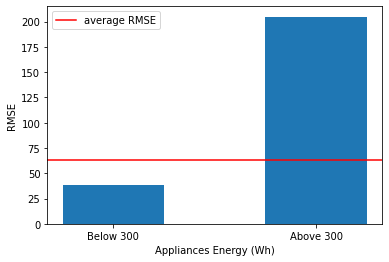

In [75]:
plt.bar(x=['Below 300', 'Above 300'], height=errors, width = 0.5)
plt.axhline(np.sqrt(mean_squared_error(y_test*sc_y.scale_ + sc_y.mean_, grid_search.best_estimator_.predict(X_test)*sc_y.scale_ + sc_y.mean_)), color='red', label='average RMSE')
plt.xlabel('Appliances Energy (Wh)')
plt.ylabel('RMSE')
plt.legend(loc='best')

In [76]:
X_test = pd.DataFrame(X_test, columns=final_features[:-1])
y_test = pd.Series(y_test, name = 'Appliances')

In [77]:
session_errors = []
for i in range(1,4):
  session_errors.append(np.sqrt(mean_squared_error(y_test[X_test.session*sc_X.scale_[-3] + sc_X.mean_[-3] == i]*sc_y.scale_ + sc_y.mean_, grid_search.best_estimator_.predict(X_test[X_test.session*sc_X.scale_[-3] + sc_X.mean_[-3] == i])*sc_y.scale_ + sc_y.mean_)))

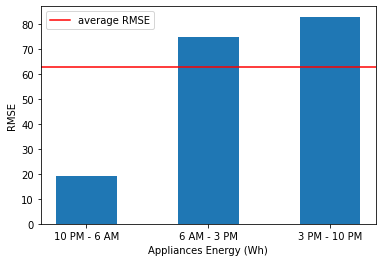

In [78]:
plt.bar(x=['10 PM - 6 AM', '6 AM - 3 PM', '3 PM - 10 PM'], height=session_errors, width = 0.5)
plt.axhline(np.sqrt(mean_squared_error(y_test*sc_y.scale_ + sc_y.mean_, grid_search.best_estimator_.predict(X_test)*sc_y.scale_ + sc_y.mean_)), color='red', label='average RMSE')
plt.xlabel('Appliances Energy (Wh)')
plt.ylabel('RMSE')
plt.legend(loc='best')

Text(0.5, 0, 'Samples')

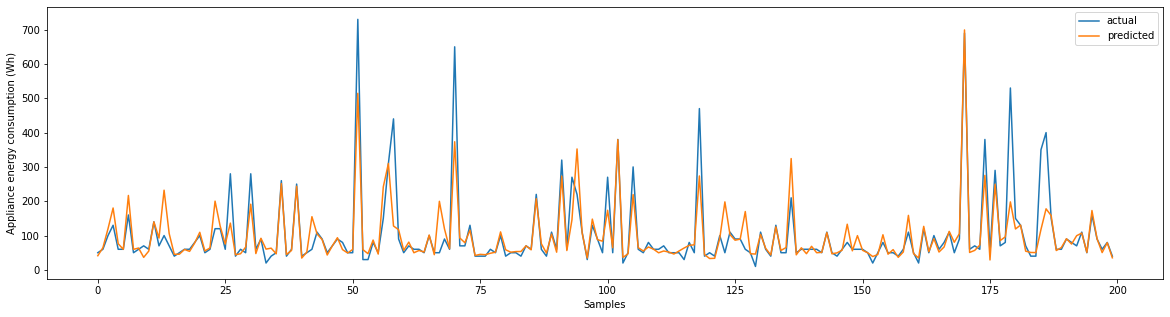

In [80]:
fig, axes = plt.subplots(1,1,figsize=(20,5))
plt.plot(range(len(y_test[:200])), y_test[:200]*sc_y.scale_ + sc_y.mean_, label='actual')
plt.plot(range(len(y_test[:200])), grid_search.best_estimator_.predict(X_test.iloc[:200,:])*sc_y.scale_ + sc_y.mean_, label='predicted')
plt.legend(loc='best')
plt.ylabel('Appliance energy consumption (Wh)')
plt.xlabel('Samples')

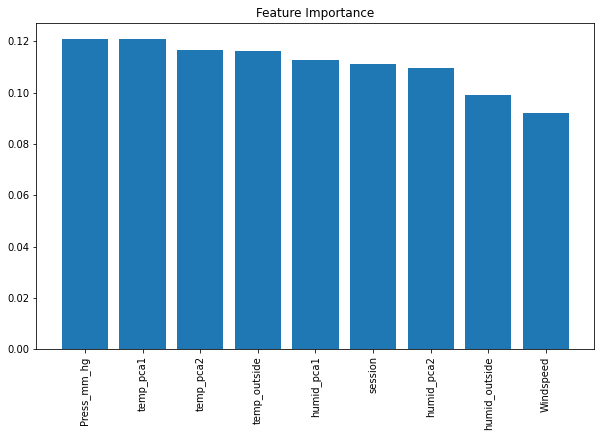

In [81]:
feature_indices = np.argsort(grid_search.best_estimator_.feature_importances_)
importances = grid_search.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
names = [final_train_df.columns[i] for i in indices]

plt.figure(figsize=(10,6))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=90)
plt.show()

**Looking at the feature importances, it is clear that the PCA features of temperature and humidity hold slightly higher feature importances compared to others.**

# **Modeling Without PCA features**

**Including all temperature and humidity features and engineered feature 'session' in our features set.**

In [82]:
final_features = ['temp_laundry','temp_bath', 'temp_kitchen', 'temp_parents', 'temp_office', 'temp_living', 'temp_teen', 'temp_iron','humid_kitchen',
 'humid_office', 'humid_bath', 'humid_living', 'humid_parents', 'humid_laundry', 'humid_teen', 'humid_iron',
  'temp_outside', 'humid_outside', 'temp_station', 'humid_station', 'session', 'Windspeed', 'Press_mm_hg', 'Appliances']

In [83]:
final_train_df, final_test_df = train_test_split(energy_df[final_features], test_size = 0.2, random_state = 1)

In [84]:
X_train, y_train = final_train_df.drop('Appliances', axis=1), final_train_df['Appliances']
X_test, y_test = final_test_df.drop('Appliances', axis=1), final_test_df['Appliances']

In [85]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [86]:
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train.values.reshape([-1,1])).flatten()
y_test = sc_y.transform(y_test.values.reshape([-1,1])).flatten()

In [87]:
models = [
           ['Lasso: ', Lasso()],
           ['Ridge: ', Ridge()],
           ['KNeighborsRegressor: ',  neighbors.KNeighborsRegressor()],
           ['SVR:' , SVR(kernel='rbf')],
           ['RandomForest ',RandomForestRegressor()],
           ['ExtraTreeRegressor :',ExtraTreesRegressor()],
           ['GradientBoostingRegressor: ', GradientBoostingRegressor()],
           ['XGBRegressor: ', xgb.XGBRegressor()],
           ['MLPRegressor: ', MLPRegressor(  activation='relu', solver='adam',learning_rate='adaptive',max_iter=1000,learning_rate_init=0.01,alpha=0.01)]
         ]

In [88]:
model_data = []
for name,curr_model in models :
    curr_model_data = {}
    curr_model.random_state = 78
    curr_model_data["Name"] = name
    start = time.time()
    curr_model.fit(X_train,y_train)
    end = time.time()
    curr_model_data["Train_Time"] = end - start
    curr_model_data["Train_R2_Score"] = r2_score(y_train,curr_model.predict(X_train))
    curr_model_data["Test_R2_Score"] = r2_score(y_test,curr_model.predict(X_test))
    curr_model_data["Test_RMSE_Score"] = np.sqrt(mean_squared_error(y_test,curr_model.predict(X_test)))
    model_data.append(curr_model_data)

[17:58:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [89]:
results_df = pd.DataFrame(model_data)

In [90]:
results_df

,Name,Train_Time,Train_R2_Score,Test_R2_Score,Test_RMSE_Score
0,Lasso:,0.009692,0.000000,-0.000777,1.028791
1,Ridge:,0.003818,0.180901,0.183926,0.929016
2,KNeighborsRegressor:,0.066099,0.680009,0.485047,0.737976
3,SVR:,16.318969,0.260418,0.236791,0.898421
4,RandomForest,32.228574,0.942477,0.591653,0.657163
5,ExtraTreeRegressor :,8.058184,1.000000,0.643406,0.614108
6,GradientBoostingRegressor:,7.413581,0.349433,0.271041,0.878031
7,XGBRegressor:,1.609254,0.347987,0.271605,0.877691
8,MLPRegressor:,7.558059,0.463050,0.394951,0.799933


**The model results are almost similar to that observed in models trained with PCA feature set.**

# **Hyper-parameter Tuning**

In [91]:
param_grid = [{
              'max_depth': [80, 150, 200,250],
              'n_estimators' : [100,150,200,250],
              'max_features': ["auto", "sqrt", "log2"]
            }]
reg = ExtraTreesRegressor(random_state=40)
grid_search = GridSearchCV(estimator = reg, param_grid = param_grid, cv = 5, n_jobs = -1 , scoring='r2' , verbose=2)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

In [ ]:
grid_search.best_estimator_.score(X_train,y_train)

In [94]:
grid_search.best_estimator_.score(X_test,y_test)

0.6434064358431634

In [95]:
np.sqrt(mean_squared_error(y_test, grid_search.best_estimator_.predict(X_test)))

0.6141083832082496

In [96]:
errors = []
errors.append(np.sqrt(mean_squared_error(y_test[y_test*sc_y.scale_ + sc_y.mean_ < 300]*sc_y.scale_ + sc_y.mean_, models[5].predict(X_test[y_test*sc_y.scale_ + sc_y.mean_ < 300,:])*sc_y.scale_ + sc_y.mean_)))

In [97]:
errors.append(np.sqrt(mean_squared_error(y_test[y_test*sc_y.scale_ + sc_y.mean_ > 300]*sc_y.scale_ + sc_y.mean_, grid_search.best_estimator_.predict(X_test[y_test*sc_y.scale_ + sc_y.mean_ > 300,:])*sc_y.scale_ + sc_y.mean_)))

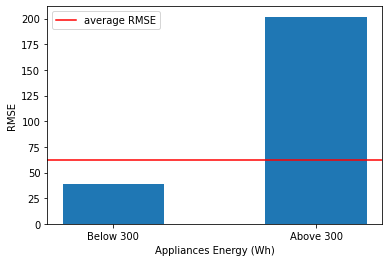

In [98]:
plt.bar(x=['Below 300', 'Above 300'], height=errors, width = 0.5)
plt.axhline(np.sqrt(mean_squared_error(y_test*sc_y.scale_ + sc_y.mean_, grid_search.best_estimator_.predict(X_test)*sc_y.scale_ + sc_y.mean_)), color='red', label='average RMSE')
plt.xlabel('Appliances Energy (Wh)')
plt.ylabel('RMSE')
plt.legend(loc='best')

In [99]:
X_test = pd.DataFrame(X_test, columns=final_features[:-1])
y_test = pd.Series(y_test, name = 'Appliances')

In [100]:
session_errors = []
for i in range(1,4):
  session_errors.append(np.sqrt(mean_squared_error(y_test[X_test.session*sc_X.scale_[-3] + sc_X.mean_[-3] == i]*sc_y.scale_ + sc_y.mean_, grid_search.best_estimator_.predict(X_test[X_test.session*sc_X.scale_[-3] + sc_X.mean_[-3] == i])*sc_y.scale_ + sc_y.mean_)))

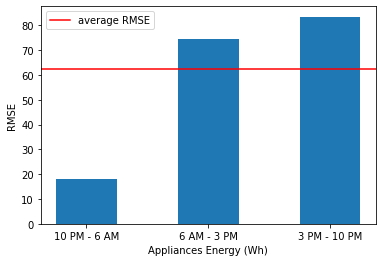

In [101]:
plt.bar(x=['10 PM - 6 AM', '6 AM - 3 PM', '3 PM - 10 PM'], height=session_errors, width = 0.5)
plt.axhline(np.sqrt(mean_squared_error(y_test*sc_y.scale_ + sc_y.mean_, grid_search.best_estimator_.predict(X_test)*sc_y.scale_ + sc_y.mean_)), color='red', label='average RMSE')
plt.xlabel('Appliances Energy (Wh)')
plt.ylabel('RMSE')
plt.legend(loc='best')

Text(0.5, 0, 'Samples')

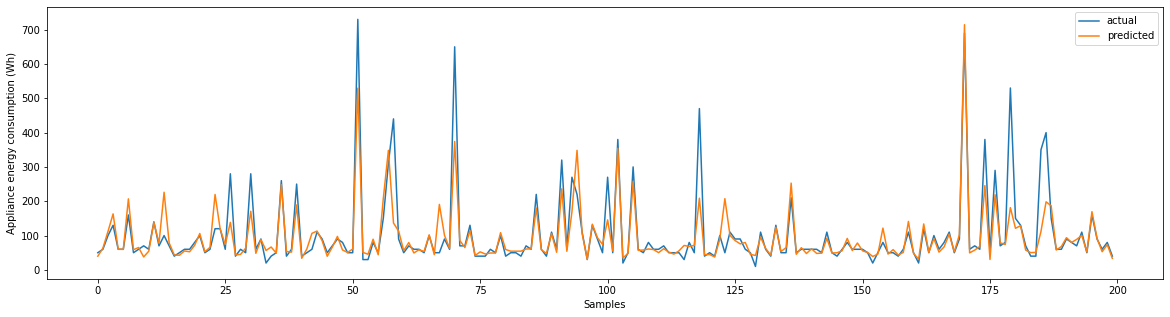

In [109]:
fig, axes = plt.subplots(1,1,figsize=(20,5))
plt.plot(range(len(y_test[:200])), y_test[:200]*sc_y.scale_ + sc_y.mean_, label='actual')
plt.plot(range(len(y_test[:200])), grid_search.best_estimator_.predict(X_test.iloc[:200,:])*sc_y.scale_ + sc_y.mean_, label='predicted')
plt.legend(loc='best')
plt.ylabel('Appliance energy consumption (Wh)')
plt.xlabel('Samples')

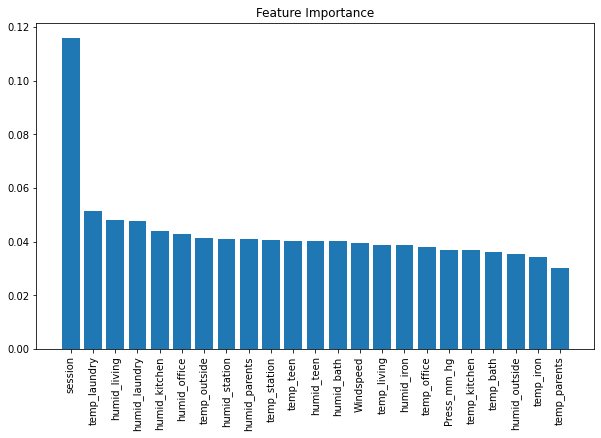

In [110]:
feature_indices = np.argsort(grid_search.best_estimator_.feature_importances_)
importances = models[5][1].feature_importances_
indices = np.argsort(importances)[::-1]
names = [final_train_df.columns[i] for i in indices]

plt.figure(figsize=(10,6))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=90)
plt.show()

**Without PCA features, the engineered feature 'session' hold most importance among all the features.**

# **Neural Networks**

In [ ]:
final_features = ['temp_pca1', 'temp_pca2', 'humid_pca1', 'humid_pca2', 'temp_outside', 'humid_outside', 'session', 'Windspeed', 'Press_mm_hg', 'weekday', 'Appliances']

In [ ]:
final_train_df, final_test_df = train_test_split(energy_df[final_features], test_size = 0.2, random_state = 1)

In [ ]:
X_train, y_train = final_train_df.drop('Appliances', axis=1), final_train_df['Appliances']
X_test, y_test = final_test_df.drop('Appliances', axis=1), final_test_df['Appliances']

In [ ]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [ ]:
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train.values.reshape([-1,1])).flatten()
y_test = sc_y.transform(y_test.values.reshape([-1,1])).flatten()

In [ ]:
def R_squared(y_true, y_pred):
  unexplained_error = tf.reduce_sum(tf.square(y_true - y_pred))
  total_error = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=0)))
  R2 = 1. - tf.truediv(unexplained_error, total_error)
  return R2

In [ ]:
NN_model = Sequential([
                    Input((None,X_train.shape[1])),
                    layers.Dense(32,activation='relu',kernel_initializer='normal'),
                    layers.Dense(64,activation='relu', kernel_initializer='normal'),
                    layers.Dense(64,activation='relu', kernel_initializer='normal'),
                    layers.Dense(1,kernel_initializer='normal',activation='linear'),
])
NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=[R_squared])
NN_model.summary()

In [ ]:
NN_model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), workers=-1)

In [ ]:
hist = NN_model.history

In [ ]:
hist.history.keys()

In [ ]:
plt.plot(range(len(hist.history['R_squared'])), hist.history['R_squared'], label = 'training')
plt.plot(range(len(hist.history['val_R_squared'])), hist.history['val_R_squared'], label = 'validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('R2 score')

# **CONCLUSION**

1. **The temperature/ humidity features showed little to no correlation w.r.t to target variable (<1%), although being highly correlation among each other.**

2. **The time zone of the day plays an important role in deciding power consumption of appliances.**

3. **The best Algorithm to use for this dataset is Extra Trees Regressor**

4. **PCA helped us to reduce our feature set dimension considerably without affcting performance of our models significantly.**

5. **The untuned model was able to explain 63% of variance on test set, while the tuned model was able to explain 64% of variance on test set which is improvement of 1.5 %**

6. **The least RMSE score on test data set is found to be around 0.6**